# Model Evaluation / Comparison

In [1]:
import torch
from tools import plot_column_from_csv, load_model, torcherize_batch, get_data_loader
from tokenizer import get_tokenizer

In [2]:
models_to_compare = [
    'baseGPT_0.5m_tall_and_skinny',
    'baseGPT_0.5m_5foot11_and_skinnyfat',
    'baseGPT_0.5m_short_and_thick'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

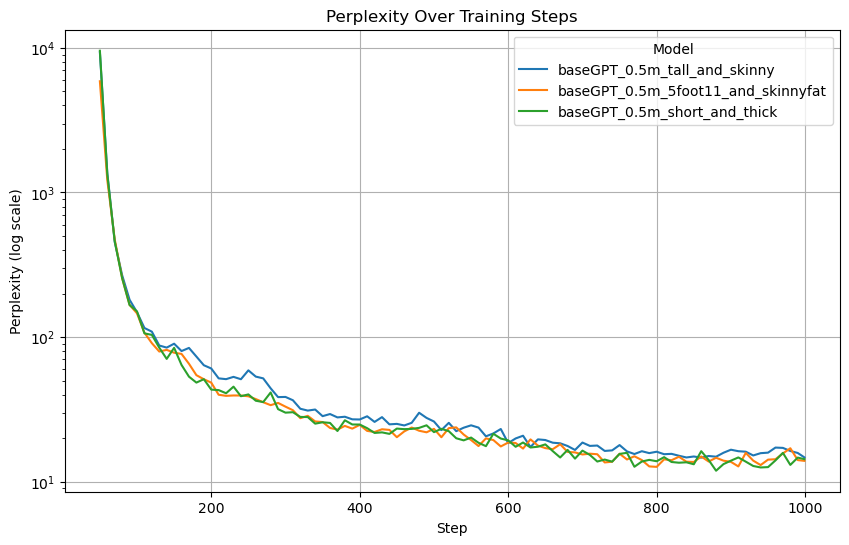

In [3]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies

In [4]:
batch_size = 1 # can only be 1 until i fix batched inference
topk = 5

In [9]:
# Data preparation
data_loader = get_data_loader(batch_size=batch_size, split='validation')
text = next(iter(data_loader))
tokenizer = get_tokenizer(2048)
x, y = torcherize_batch(tokenizer, text)  # x and y are tensors shape [batch_size, 512] of dtype torch.int64

print(text[0])
# we want to make sure to choose a y value that takes advantage of the full context for the best estimate,
# so avoid stories that are too short and have padding tokens at teh end
print(y)

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


Sara was sick. She had a fever and a sore throat. She did not want to play or eat. She only wanted to lie in bed and cry.
Her mom called the nurse. The nurse came to Sara's house. She had a bag with tools and medicine. She smiled at Sara and said, "Hello, Sara. I am here to help you feel better. Can I check your temperature and your throat?"
Sara nodded. She was scared, but she trusted the nurse. The nurse put a stick in Sara's mouth and a band on her arm. She looked at the numbers and said, "You have a high fever, Sara. You need some medicine and some cool water. This will help you fight the germs that make you sick."
The nurse gave Sara a spoon with medicine. It tasted bad, but Sara swallowed it. The nurse also gave Sara a cup with cool water. It felt good on Sara's throat. The nurse said, "Good job, Sara. You are very brave. You need to rest and drink more water. I will come back tomorrow to see how you are doing."
Sara thanked the nurse. She felt a little better. She hugged her mom

In [10]:
# Function to calculate top-k accuracy
def calculate_topk_accuracy(logits, targets, k=5):
    topk_indices = torch.topk(logits, k, dim=2).indices
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices))
    return correct.any(dim=2).float().mean()

In [11]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    model, _, _ = load_model(model_name)
    model.eval()
    with torch.no_grad():
        logits, _ = model(x)
    
    topk_accuracy = calculate_topk_accuracy(logits, y, k=topk)
    topk_values, topk_indices = torch.topk(logits, topk, dim=2)
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'topk_values': topk_values
    }

ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=10, second_resid_norm=False, mlp_hidden_mult=1, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=10, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 502.592 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=8, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=8, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 493.888 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=16, num_kv_heads=4, head_dim=16, theta=10000, max_seq_len=512, scale_first_resi

In [12]:
# Define a function to format the model output
def format_model_output(model_name, data, topk):
    print(f"Model: {model_name}")
    print(f"  - Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    
    # Fetch the top-k predictions for the last token and decode each token
    top_predictions = data['topk_indices'][:,-1,:].squeeze(0).tolist()
    print("  - Top predictions for the last token:")
    for token_index in top_predictions:
        decoded_token = tokenizer.decode([token_index])
        print(f"    - Index: {token_index}, Token: {decoded_token}")
    print()

# Display the results for each model
for name, data in results.items():
    format_model_output(name, data, topk)

# Show the correct value and its decoded form
correct_value = y[:,-1].tolist()
decoded_correct_value = tokenizer.decode(correct_value)
print(f"Correct value: {correct_value[0]} = {decoded_correct_value}")

Model: baseGPT_0.5m_tall_and_skinny
  - Top-5 Accuracy: 56.25%
  - Top predictions for the last token:
    - Index: 2, Token:  
    - Index: 98, Token:  a
    - Index: 153, Token:  s
    - Index: 206, Token:  t
    - Index: 65, Token: a

Model: baseGPT_0.5m_5foot11_and_skinnyfat
  - Top-5 Accuracy: 55.86%
  - Top predictions for the last token:
    - Index: 2, Token:  
    - Index: 153, Token:  s
    - Index: 98, Token:  a
    - Index: 206, Token:  t
    - Index: 65, Token: a

Model: baseGPT_0.5m_short_and_thick
  - Top-5 Accuracy: 57.23%
  - Top predictions for the last token:
    - Index: 2, Token:  
    - Index: 153, Token:  s
    - Index: 98, Token:  a
    - Index: 206, Token:  t
    - Index: 149, Token:  h

Correct value: 1204 =  g


# once i fix batched inference i need to redo the above code to use that to get a more accurate measurement. also should add some logic to ensure that padding tokens don't get graded and the example is one that doesn't show padding tokens

# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper

# also once the hyperparameter search module is working i should build a system that performs a regression on the hyperparameters tested to predict teacher-forcing topk accuracy. likely need to include both linear, quadratic, & interaction terms in the regression and then do a lasso to remove useless terms